# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from logging.handlers import RotatingFileHandler
from logging import Formatter

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

In [2]:
def logger_setup() -> logging.Logger:
    date_time_str = time.strftime(r"%Y-%m-%d_%H-%M-%S")

    # Configure the root logger to a particular folder, format, and level.
    # Lower the level when things are working better or worse.
    root_logger = logging.getLogger()
    path = os.path.dirname('..\\')
    
    handler = RotatingFileHandler(filename=path+f"\\logging\\runtime_test.log",
        backupCount=8,encoding="utf-8")
    handler.doRollover()

    formatter = Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.DEBUG)
    logger = logging.getLogger(__name__)
    logger.info("Debug log for the robot starting on " + date_time_str)
    return logger

logger = logger_setup()

### Unload the data from a particular scan
This should only include data from a Fullscan module

In [3]:
path = os.path.abspath('..\\')
test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [4]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = np.array(json_data["max_point"])

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array(point_mags)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")

data = pd.DataFrame(data=points, columns=cols)

points = data[active_rom]
mags = data['mag']
mp = data.loc[data['mag'].idxmax()]

In [5]:
print(points.shape)
print(mags.shape)
linInter = LinearNDInterpolator(points,mags,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)
# Usually takes about 25 seconds for test_6

(51749, 3)
(51749,)
Active range of motion: ['Z', 'Rx', 'Ry']
[-14.0, -13.0, -12.0, 216.071]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [-13, 13], 'Ry': [-13, 13], 'Rz': [0, 0]}
(51749, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 14.0, 'Rx': 13.0, 'Ry': 13.0, 'Rz': 0.0}
[0.4, 1]


In [23]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
expansion = 1.5
scanner = Gradient_Ascent(r['Z']*expansion, r['Rx']*expansion, r['Ry']*expansion,bias=1,steps=4,speed=2)

p = scanner.next()
i = 0

offset = np.array([0,0,-2,-5,6,0])

while type(p) is not int and i < 2500:
    i += 1

    request = p + offset
    request = request[scanner.save_indices[0:-1]]
    # print(f"Reuqest: {request}")
    mag = linInter(request)

    if mag[0] == -1:
        mag[0] = i * -20
    # print(f"magnitudes:{mag}")
    # print(f"Value pushed: {np.append(p,mag[0])}")

    scanner.newMag(np.append(p,mag[0]),True)
    p = scanner.next()
    print(f"Request: {request}\t\tMag: {mag}\tpoint: {np.append(request,mag[0])},\tLoop {i}                                 ",end="\r")
    # print('\n'.join(prin), end=(len(prin) + 1)*'\033[F')

print()
print(p)
if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)

point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

cols = active_rom.copy()
cols.append("mag")

print(len(point_mags_2))

scanner_dat = np.array(scanner.points)

scanner_data = pd.DataFrame(data=scanner_dat, columns=cols)

print(scanner_data.head())
a = np.array(point_mags_2[0])
distance = 0

for i in range(1, len(point_mags_2)):
    b = np.array(point_mags_2[i])
    t = np.sum((b - a)**2)

    distance += t**0.5
    a = b

# (x,y,z,Rx,Ry,Rz,mag) = search_max.tolist()
# search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)
search_max = search_max + np.append(offset.copy(),0)


t = np.sum((scan_max[:3] - search_max[:3])**2)
lin_dist = t**0.5

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[3] - search_max[3])) 
            * np.cos(np.deg2rad(scan_max[4] - search_max[4])))

print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value:\t\t{scan_max}")
print(f"\tSearch max value:\t{search_max}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")

Request: [ 2.85 -0.33 -3.30]		Mag: [ 512.44]	point: [ 2.85 -0.33 -3.30  512.44],	Loop 71                                 
1
Number of points to solve: 71
71
     Z   Rx   Ry      mag
0  0.0  0.0  0.0  66.9880
1  0.0  0.0  0.0  66.9880
2 -0.8 -0.8 -1.6  64.5160
3  0.8 -0.8 -1.6  89.9074
4 -0.8  0.8 -1.6  61.0678
Pathfinder evalutation: 
	Total search-space distance traveled: 2705.7452075509286
	Scan max value:		[ 0.00  0.00  2.40  0.00  1.00  0.00  621.20]
	Search max value:	[ 0.00  0.00  2.45 -0.92 -2.12  0.00  587.69]
	Offsets: [ 0  0 -2 -5  6  0]
	Distance from target to found value: 0.04526070956125583 mm, 0.056854866503626596 deg


In [24]:
# print(scanner_data.to_string())
# print(scanner_dat)
a = np.array([1,2,3,4,5,6,7])
a[:6]

array([1, 2, 3, 4, 5, 6])

(-1.0784368248801588, 6.5259978295483325)
(-11.71951479398968, 3.666460434482246)
(-5.1336187915659135, 6.152417135298013)


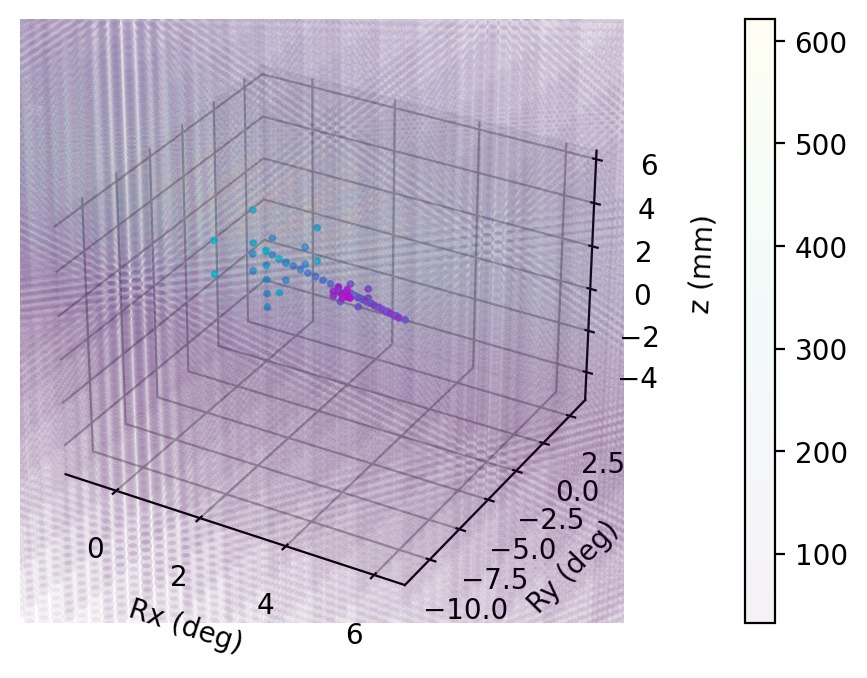

In [25]:
ax = plt.axes(projection='3d')
fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap='viridis', alpha=0.05, linewidth=0.02)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))


ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)
